In [1]:
!pip install rasterio

In [1]:
import azureml.core
from azureml.core import Experiment, Workspace, Dataset, Datastore, ScriptRunConfig, Model
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies
import os
import shutil
import glob
from os.path import join
import tensorflow as tf
from tensorflow.python.keras import models
from sys import path
import numpy as np
import rasterio as rio
import json

# check core SDK version number

print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.28.0


In [3]:
# make sure we have the most current version of github repo
%cd Satellite_ComputerVision
!git pull
%cd ..

[Errno 2] No such file or directory: 'Satellite_ComputerVision'
/mnt/batch/tasks/shared/LS_root/mounts/clusters/wetlandsbasiccpu/code/Users/mevans/Wetland_UNet
Already up to date.
/mnt/batch/tasks/shared/LS_root/mounts/clusters/wetlandsbasiccpu/code/Users/mevans


In [3]:
# attach our utilities folder to the path to import modules
path.append('/home/azureuser/cloudfiles/code/Users/mevans/Wetland_UNet/azure/scv')

In [4]:
from utils.model_tools import get_binary_model, make_confusion_matrix, weighted_bce
from utils.processing import get_training_dataset, normalize
from utils.prediction_tools import make_pred_dataset, make_array_predictions, write_geotiff_prediction

In [2]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
# get metadata about the workspace
print(ws.name, ws.location, ws.resource_group, sep='\t')
# list the registered datastores
ws.datastores

wetlands	eastus	cic_ai


{'workspaceartifactstore': {
   "name": "workspaceartifactstore",
   "container_name": "azureml",
   "account_name": "wetlands2489098639",
   "protocol": "https",
   "endpoint": "core.windows.net"
 },
 'wetlanddatastore': {
   "name": "wetlanddatastore",
   "container_name": "data",
   "account_name": "wetlands2489098639",
   "protocol": "https",
   "endpoint": "core.windows.net"
 },
 'workspacefilestore': {
   "name": "workspacefilestore",
   "container_name": "azureml-filestore-2640f222-8801-40ec-b413-83a7ec003a55",
   "account_name": "wetlands2489098639",
   "protocol": "https",
   "endpoint": "core.windows.net"
 },
 'workspaceblobstore': {
   "name": "workspaceblobstore",
   "container_name": "azureml-blobstore-2640f222-8801-40ec-b413-83a7ec003a55",
   "account_name": "wetlands2489098639",
   "protocol": "https",
   "endpoint": "core.windows.net"
 }}

In [3]:
# access our registered data share containing image data in this workspace
datastore = Datastore.get(workspace = ws, datastore_name = 'wetlanddatastore')

train_path = (datastore, 'summerReplicated/training/')
eval_path = (datastore, 'summerReplicated/eval/')

# aoi = 'test_aoi_Kumar_LES'
aoi = 'aoi_LES_entire'
test_path = (datastore, f'summerReplicated/predict/{aoi}')

train_dataset = Dataset.File.from_files(path = [train_path])
eval_dataset = Dataset.File.from_files(path = [eval_path])
test_dataset = Dataset.File.from_files(path = [test_path])

In [4]:
experiment_name = 'wetland-unet-predict'
exp = Experiment(workspace = ws, name = experiment_name)

In [5]:
run_id = 'wetland-unet-les_1648737274_0520f70d'

run = ws.get_run(run_id)

run.tags

model_name = 'wetland-unet-basic-LES'

In [8]:
# alternatively, get our model and weights file from a run
runFiles = run.get_file_names()
runFiles
run.download_files(prefix = 'outputs/', output_directory = run_id)

In [11]:
%cd ..
root = !pwd
model_dir = f'{root[0]}/{run_id}/outputs'
weight_path = glob.glob(os.path.join(model_dir, '*.hdf5'))
weight_path

/mnt/batch/tasks/shared/LS_root/mounts/clusters/wetlandsgpu/code/Users/mevans


['/mnt/batch/tasks/shared/LS_root/mounts/clusters/wetlandsgpu/code/Users/mevans/wetland-unet-les_1648737274_0520f70d/outputs/best_weights_31Mar22_06.hdf5',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/wetlandsgpu/code/Users/mevans/wetland-unet-les_1648737274_0520f70d/outputs/best_weights_31Mar22_08.hdf5',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/wetlandsgpu/code/Users/mevans/wetland-unet-les_1648737274_0520f70d/outputs/best_weights_31Mar22_13.hdf5',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/wetlandsgpu/code/Users/mevans/wetland-unet-les_1648737274_0520f70d/outputs/best_weights_31Mar22_27.hdf5',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/wetlandsgpu/code/Users/mevans/wetland-unet-les_1648737274_0520f70d/outputs/best_weights_31Mar22_33.hdf5',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/wetlandsgpu/code/Users/mevans/wetland-unet-les_1648737274_0520f70d/outputs/best_weights_31Mar22_36.hdf5']

In [6]:
# if we haven't already registered our model
model = run.register_model(model_name= model_name,
                           tags=run.tags,
                           description = 'UNET model delineating wetlands using Sentinel-2, NAIP data from LES.',
                           model_path='outputs/',
                           model_framework = 'Tensorflow',
                           model_framework_version= '2.0',
                           datasets = [('training', train_dataset), ('evaluation', eval_dataset), ('testing', test_dataset)])
print(model.name, model.id, model.version, sep='\t')

wetland-unet-basic-LES	wetland-unet-basic-LES:3	3


In [46]:
# get our model and weights files if the model has been registered
model_dir = Model.get_model_path(model_name, _workspace = ws)
weight_path = glob.glob(os.path.join(model_dir, '*.hdf5'))
weight_path[0]

'azureml-models/wetland-unet-basic/6/outputs/best_weights_28Jun21.hdf5'

In [10]:
# Define some global variabes

# specify surface layers
lidar = ['lidar_intensity']
geomorphon = ["geomorphons"]

# Specify inputs (Sentinel bands) to the model
opticalBands = ['B3', 'B4', 'B5', 'B6']
thermalBands = ['B8', 'B11', 'B12']
senBands = opticalBands + thermalBands

# get band names for three seasons
seasonalBands = [[band+'_summer', band + '_fall', band + '_spring'] for band in senBands]


# specify NAIP bands
naipBands = ['R', 'G', 'B', 'N']

BANDS = [item for sublist in seasonalBands for item in sublist] + naipBands# + lidar + geomorphon
RESPONSE = 'wetland'
FEATURES = BANDS + [RESPONSE]
ONE_HOT = {'geomorphons':11}
print(FEATURES)
# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 256
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
DEPTH = len(BANDS)#+sum(ONE_HOT.values())-len(ONE_HOT.values())
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

METRICS = {
    'logits':[tf.keras.metrics.MeanSquaredError(name='mse'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
    'classes':[tf.keras.metrics.MeanIoU(num_classes=2, name = 'mean_iou')]
    }

['B3_summer', 'B3_fall', 'B3_spring', 'B4_summer', 'B4_fall', 'B4_spring', 'B5_summer', 'B5_fall', 'B5_spring', 'B6_summer', 'B6_fall', 'B6_spring', 'B8_summer', 'B8_fall', 'B8_spring', 'B11_summer', 'B11_fall', 'B11_spring', 'B12_summer', 'B12_fall', 'B12_spring', 'R', 'G', 'B', 'N', 'wetland']


In [12]:
def get_weighted_bce(y_true,y_pred):
  return weighted_bce(y_true, y_pred, 1)
# m = models.load_model('azureml-models/wetland-unet-basic/5/outputs/unet256.h5', custom_objects = {'get_weighted_bce': get_weighted_bce})
m = get_binary_model(depth = DEPTH, optim = OPTIMIZER, loss = get_weighted_bce, mets = METRICS, bias = None)
# basic model
# m.load_weights('azureml-models/wetland-unet-basic/5/outputs/best_weights_23Jun21.hdf5')
# wlidar model
m.load_weights(weight_path[-1])
# # wgeomorphon model
# m.load_weights('azureml-models/wetland-unet-wgeomorphon/2/outputs/best_weights_25Jun21.hdf5')
# # full model
# m.load_weights('azureml-models/wetland-unet-full/2/outputs/best_weights_24Jun21.hdf5')

In [13]:
# Create mountcontext and mount the dataset
with test_dataset.mount() as test_mount:

    # Get the mount point
    dataset_mount_folder = test_mount.mount_point
    print(dataset_mount_folder)

    # for root, dirs, files in os.walk(dataset_mount_folder):
    #     for f in files:
    #         testFiles.append(join(root, f))

    predFiles = glob.glob(os.path.join(dataset_mount_folder, '*.gz'))
    jsonFile = glob.glob(os.path.join(dataset_mount_folder, '*.json'))

    predData = make_pred_dataset(predFiles, BANDS, one_hot = None)
    iterator = iter(predData)
    print(iterator.next())

    preds = make_array_predictions(imageDataset = predData, model = m, jsonFile = jsonFile[0])

/tmp/tmpwm9lrmth
Downloaded path: /tmp/tmp2ybuc_rd/75dbd02c-a211-40c8-b2ab-0dccf4ae11b6/summerReplicated/predict/test_aoi_Kumar_LES/raw_unet256_test_aoi_Kumar_LES00000.tfrecord.gz is different from target path: /tmp/tmp2ybuc_rd/75dbd02c-a211-40c8-b2ab-0dccf4ae11b6/raw_unet256_test_aoi_Kumar_LES00000.tfrecord.gz
tf.Tensor(
[[[[ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   ...
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]]

  [[ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.    

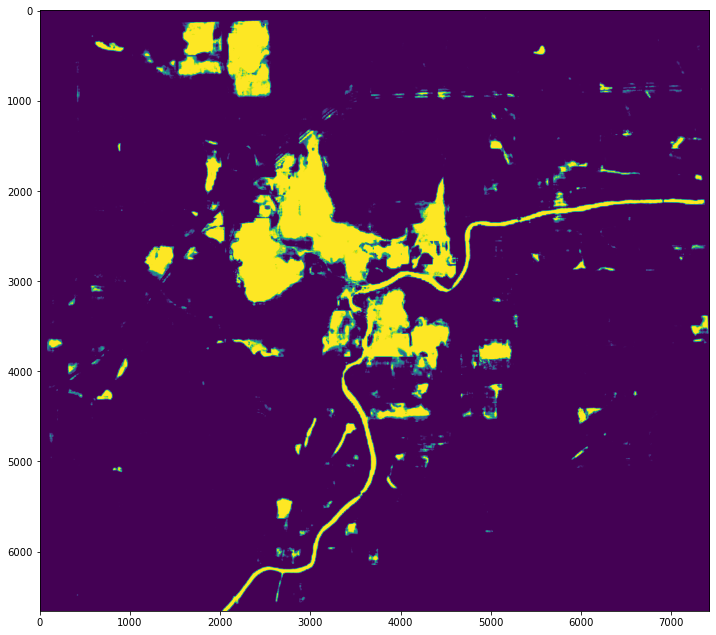

In [14]:
# We can visualize the predictions here in the notebook
from matplotlib import pyplot as plt
from matplotlib import colors

figure = plt.figure(figsize = (12,12))
# cmap = colors.ListedColormap(['#5dc5f1', '#50a886', '#3d6e1d', '#80e144', '#bafb85', '#d4a13e', "#e73522", "#9c9c9c", "#000000", "#706e22", "#e7e64b", "#fefc86", '#ad36ed'])
prob = preds[:, :, 0]
# cls = out_image[:, :, 0]

plt.imshow(prob)#, norm = colors.BoundaryNorm([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], cmap.N), cmap = cmap)

In [27]:
write_geotiff_predictions(predFiles, m, jsonFile[0], BANDS, 50, 'MN_test_basic', './', export = False)

Downloaded path: /tmp/tmpj915bxd2/d3c275c3-86ed-49c6-8694-492ed3da5645/data/predict/test_aoi_David2_MN/raw_unet256_test_aoi_David2_MNmixer.json is different from target path: /tmp/tmpj915bxd2/d3c275c3-86ed-49c6-8694-492ed3da5645/raw_unet256_test_aoi_David2_MNmixer.json
Downloaded path: /tmp/tmpj915bxd2/d3c275c3-86ed-49c6-8694-492ed3da5645/data/predict/test_aoi_David2_MN/raw_unet256_test_aoi_David2_MN00000.tfrecord.gz is different from target path: /tmp/tmpj915bxd2/d3c275c3-86ed-49c6-8694-492ed3da5645/raw_unet256_test_aoi_David2_MN00000.tfrecord.gz
Downloaded path: /tmp/tmpj915bxd2/d3c275c3-86ed-49c6-8694-492ed3da5645/data/predict/test_aoi_David2_MN/raw_unet256_test_aoi_David2_MN00001.tfrecord.gz is different from target path: /tmp/tmpj915bxd2/d3c275c3-86ed-49c6-8694-492ed3da5645/raw_unet256_test_aoi_David2_MN00001.tfrecord.gz
Downloaded path: /tmp/tmpj915bxd2/d3c275c3-86ed-49c6-8694-492ed3da5645/data/predict/test_aoi_David2_MN/raw_unet256_test_aoi_David2_MN00002.tfrecord.gz is differen

In [20]:
write_geotiff_prediction(prob, jsonFile[0], 'DE_test_basic')

## Predict using submitted run

In [8]:
# create script run config
# use the azure folder as our script folder

script_folder = 'Wetland_UNet/azure'
script_file = 'predict_wetland.py'

In [9]:
env = ws.environments['wetland-training']
compute = ws.compute_targets['wetlandsGPU']
experiment_name = 'wetland-unet-predict'
exp = Experiment(workspace = ws, name = experiment_name) 

In [10]:
# define the command line arguments to our training sript
mod = 'basic-LES'
args = [
    '--data_dir', test_dataset.as_mount(),
    '--model_id', f'wetland-unet-{mod}',
    '--aoi', aoi]

In [11]:
#  run the training job
src = ScriptRunConfig(source_directory=script_folder,
                      script=script_file, 
                      arguments=args,
                      compute_target=compute,
                      environment=env)
run = exp.submit(config=src, tags = {'aoi':f'{aoi}', 'model':f'{mod}'})
run

Experiment,Id,Type,Status,Details Page,Docs Page
wetland-unet-predict,wetland-unet-predict_1648752888_75a6fc28,azureml.scriptrun,Preparing,Link to Azure Machine Learning studio,Link to Documentation


## Let's look at the predictions made by our submitted jobs

In [2]:
import rasterio as rio


In [24]:
run.download_file(name = 'outputs/aoi_LES_entire_basic.tif', output_file_path = './Users/mevans/LES.tif')

In [25]:
with rio.open('./Users/mevans/LES.tif') as src:
    preds = src.read()
    shp = src.shape

In [26]:
preds.max()

1.0

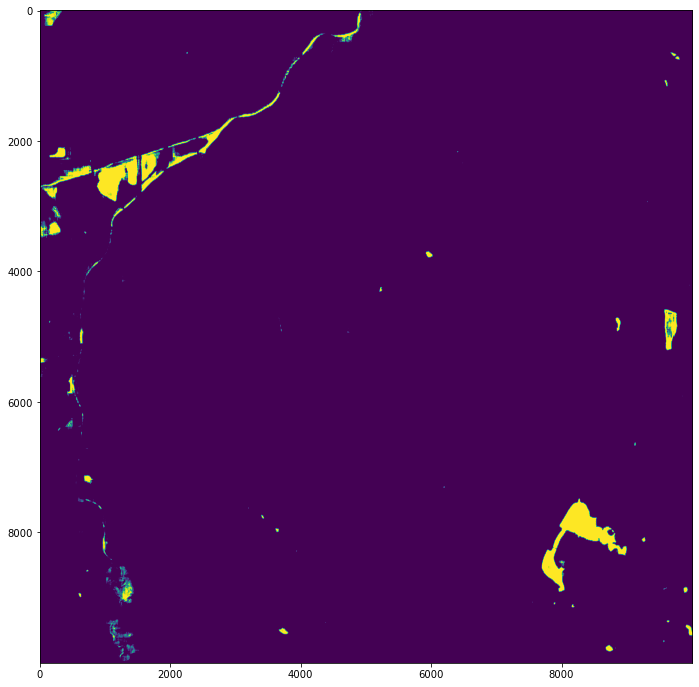

In [27]:
# We can visualize the predictions here in the notebook
from matplotlib import pyplot as plt
from matplotlib import colors

figure = plt.figure(figsize = (12,12))
# cmap = colors.ListedColormap(['#5dc5f1', '#50a886', '#3d6e1d', '#80e144', '#bafb85', '#d4a13e', "#e73522", "#9c9c9c", "#000000", "#706e22", "#e7e64b", "#fefc86", '#ad36ed'])
prob = preds[0, 10000:20000, 10000:20000]
# cls = out_image[:, :, 0]

plt.imshow(prob)#, norm = colors.BoundaryNorm([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], cmap.N), cmap = cmap)